In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask import delayed, compute
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib widget
import os
from typing import Optional, List
import time
import itertools

from helpers import classify_hypothesis_n_agents, get_dataset, classify_with_different_configurations

Set up Dask client for distributed computing

In [2]:
from dask_jobqueue import SGECluster
from dask.distributed import Client

n_workers = 120

cluster = SGECluster(
    cores=1,
    memory="1GB",
    processes=1,
    queue="short.q",
    job_extra_directives=[f"-t 1-{n_workers}"],
    log_directory=os.path.join(os.environ["HOME"], "logs/"),
    local_directory=os.path.join(os.environ["HOME"], "dask-worker-space/"),
    walltime="01:59:00",
    name="cis7000-{$SGE_TASK_ID}",
)
client = Client(cluster)
cluster.scale(n=1)


In [3]:
# set seed
np.random.seed(42)
temp = 0.1

# Config
few_shot = [1, 4, 8, 16, 32, 48, 64, 80, 96]
agents = [1, 3, 5, 9, 15]

# The batch size of new samples
n_test_samples = 1000


@delayed
def process_sample(row) -> dict:
    sample_premise = row["premise"]
    sample_hypothesis = row["hypothesis"]
    sample_label = row["label"]
    shot = row["few_shot"]
    agent = row["n_agents"]

    # Get the prediction with combination of agents and few shot examples
    results = classify_hypothesis_n_agents(
        premise=sample_premise,
        hypothesis=sample_hypothesis,
        label=sample_label,
        n_agents=agent,
        m_examples=shot,
        temp=temp,
    )
    new_row = {
        "sample_id": row["sample_id"],
        "premise": sample_premise,
        "hypothesis": sample_hypothesis,
        "n_agents": agent,
        "m_examples": shot,
        "label": sample_label,
        **results,
    }
    return new_row


test_data = get_dataset(split="test")
test_data = test_data.query("label != -1")
test_data = test_data.drop_duplicates(subset=["premise"])
test_data = test_data.drop_duplicates(subset=["hypothesis"])
test_samples = test_data.sample(n_test_samples)
# Create a product of all combinations
combinations = pd.MultiIndex.from_product(
    [test_samples.index, few_shot, agents], names=["sample_id", "few_shot", "n_agents"]
)

# Create expanded DataFrame with all combinations
expanded_df = pd.DataFrame(index=combinations).reset_index()

# Merge with original samples
final_df = expanded_df.merge(test_samples, left_on="sample_id", right_index=True)

dask_df = dd.from_pandas(final_df, npartitions=n_workers)  # Adjust the number of partitions as needed

delayed_results = [process_sample(row) for _, row in dask_df.iterrows()]
results = compute(*delayed_results)

# Flatten the list of results and create a DataFrame
df_results = pd.DataFrame(results)

# Debugging: Check if df_results is empty
if df_results.empty:
    print("Warning: df_results is empty. No data to save.")
else:
    # Save results with error handling
    try:
        df_results.to_csv(f"data/grid_results_temp_{temp}.csv", index=False)
        print("Results saved!")
    except Exception as e:
        print(f"Error saving results: {e}")


/home/mnt/weka/jrudoler/cis7000-multi-agent/.venv/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 22.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Results saved!


In [2]:
vote_type = "majority"
df_results = pd.read_csv("data/grid_results_temp_0.1.csv")
df_results["result_majority"] = df_results["vote_majority"] == df_results["label"]
df_results["result_mean"] = df_results["vote_mean"] == df_results["label"]
pivot_df = (
    df_results.groupby(["n_agents", "m_examples"])
    .agg(
        performance=(f"result_{vote_type}", "mean"),
        count=(f"result_{vote_type}", "count"),  # Count for standard error calculation
        sem=(f"result_{vote_type}", "sem"),  # Standard deviation for standard error, ddof=1 by default
    )
    .reset_index()
)

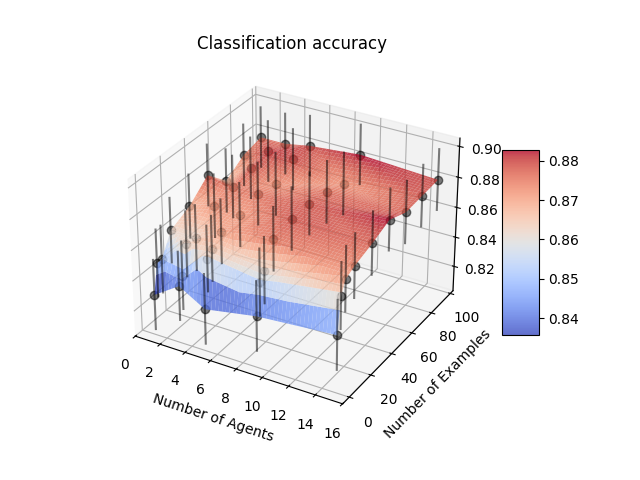

In [3]:
# Assuming pivot_df is already created as shown in your code
# pivot_df contains columns: 'n_agents', 'm_examples', 'performance', 'sem'

def plot_performance(pivot_df, interpolate=True, granularity=100):
    # Create a meshgrid for n_agents and m_examples
    n_agents_unique = pivot_df["n_agents"].unique()
    m_examples_unique = pivot_df["m_examples"].unique()
    n_agents_grid, m_examples_grid = np.meshgrid(n_agents_unique, m_examples_unique)

    # Reshape performance and sem to match the grid
    performance_grid = pivot_df.pivot(index="m_examples", columns="n_agents", values="performance").values
    sem_grid = pivot_df.pivot(index="m_examples", columns="n_agents", values="sem").values

    if interpolate:
        # Define a finer grid for interpolation
        n_agents_fine = np.linspace(n_agents_unique.min(), n_agents_unique.max(), granularity)
        m_examples_fine = np.linspace(m_examples_unique.min(), m_examples_unique.max(), granularity)
        n_agents_fine_grid, m_examples_fine_grid = np.meshgrid(n_agents_fine, m_examples_fine)

        # Interpolate the performance data
        points = np.array([n_agents_grid.flatten(), m_examples_grid.flatten()]).T
        values = performance_grid.flatten()
        performance_fine_grid = griddata(points, values, (n_agents_fine_grid, m_examples_fine_grid), method="linear")

        # Use the interpolated grid for plotting
        x_grid, y_grid, z_grid = n_agents_fine_grid, m_examples_fine_grid, performance_fine_grid
    else:
        # Use the original grid for plotting
        x_grid, y_grid, z_grid = n_agents_grid, m_examples_grid, performance_grid

    # Plotting
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Surface plot
    surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap="coolwarm", alpha=0.8, antialiased=True)

    # Plot error bars using the original grid
    ax.errorbar(
        n_agents_grid.flatten(),
        m_examples_grid.flatten(),
        performance_grid.flatten(),
        zerr=2 * sem_grid.flatten(),
        fmt="o",
        color="k",
        alpha=0.5,
    )

    # Labels and title
    ax.set_xlabel("Number of Agents")
    ax.set_ylabel("Number of Examples")
    ax.set_zlabel("Performance")
    ax.set_title("Classification accuracy")

    # reverse the y axis
    # ax.invert_xaxis()

    # Add a color bar which maps values to colors
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.show()
    return fig


# Example usage:
fig = plot_performance(pivot_df, interpolate=True, granularity=200)


In [15]:
plt.savefig("figures/performance_plot.pdf")

## Same sample, different configurations

In [3]:
np.random.seed(42)
temp = 0.1


@delayed
def process_sample_with_configurations(row, total_m_examples, configurations: Optional[List[List[int]]] = None) -> dict:
    sample_premise = row["premise"]
    sample_hypothesis = row["hypothesis"]
    sample_label = row["label"]

    # returns a list of dictionaries with the results for each configuration
    results, configurations, indices = classify_with_different_configurations(
        premise=sample_premise,
        hypothesis=sample_hypothesis,
        total_m_examples=total_m_examples,
        configurations=configurations,
        temp=temp,
    )

    # create a new row with the results
    new_rows = [
        {
            "sample_id": row["sample_id"],
            "premise": sample_premise,
            "hypothesis": sample_hypothesis,
            "label": sample_label,
            "n_agents": configurations[i][0],
            "m_examples": configurations[i][1],
            "indices": indices,
            **results[i],
        }
        for i in range(len(results))
    ]
    return new_rows


# create dataframe with input samples and sample index named sample_id
n_test_samples = 1000

test_data = get_dataset(split="test")
test_data = test_data.query("label != -1")
test_data = test_data.drop_duplicates(subset=["premise"])
test_data = test_data.drop_duplicates(subset=["hypothesis"])
test_samples = test_data.sample(n_test_samples)
test_samples = test_samples.reset_index(drop=False).rename(columns={"index": "sample_id"})

# Split the test samples into parts to avoid rate limits
num_parts = 10
part_size = len(test_samples) // num_parts
results = []

for idx in itertools.batched(range(len(test_samples)), part_size):
    part_samples = test_samples.iloc[idx[0] : (idx[-1] + 1)]
    part_samples = dd.from_pandas(part_samples, npartitions=n_workers)

    # Process the current part
    delayed_results = [process_sample_with_configurations(row, 288) for _, row in part_samples.iterrows()]
    results_part = compute(*delayed_results)

    # Sleep to avoid rate limits
    time.sleep(60)

    # Combine results
    results.extend(results_part)


# # if not worried about the rate limits, we can use the following code
# test_samples = dd.from_pandas(test_samples, npartitions=n_workers)
# results = [process_sample_with_configurations(row, 288) for _, row in test_samples.iterrows()]
# results = compute(*results)

# # flatten the list of results
results = [item for sublist in results for item in sublist]

# create a dataframe with the results
results_df = pd.DataFrame(results)

results_df["result_majority"] = (results_df["vote_majority"] == results_df["label"]).astype(int)
results_df["result_mean"] = (results_df["vote_mean"] == results_df["label"]).astype(int)

# results_df.to_csv(f"data/same_sample_different_configurations_temp_{temp}.csv", index=False)

144 144 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
144 144 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
144 144 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
144 144 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
144 144 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
144 144 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 1 [144 144   0   0   0   0   0   0   0

/mnt/tmp/641973.1.mem.q/ipykernel_1430833/3571664113.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")


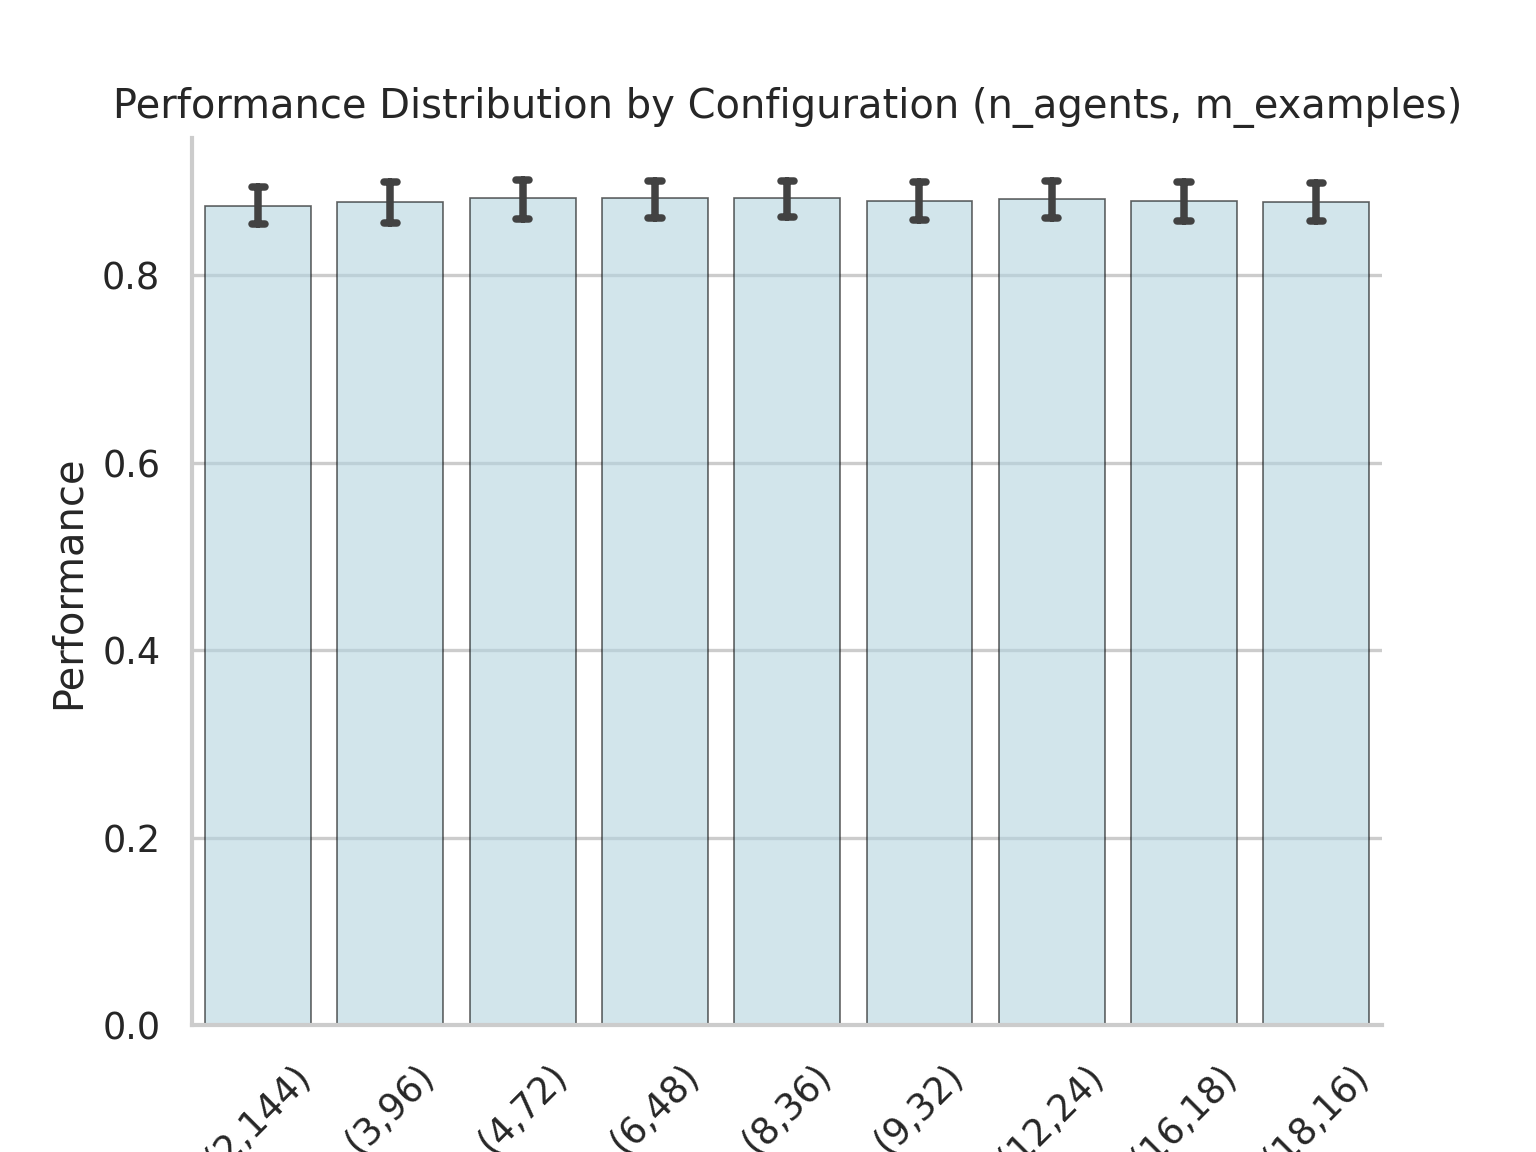

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.clf()

temp = 0.1
results_df = pd.read_csv(f"data/same_sample_different_configurations_temp_{temp}.csv")

# Assuming results_df has columns: 'n_agents', 'm_examples', 'result_majority', 'result_mean'
# You can choose either 'result_majority' or 'result_mean' as the performance metric

# Create a new column to represent the (n_agents, m_examples) pair as a string
results_df["config"] = results_df.apply(lambda row: f"({row['n_agents']},{row['m_examples']})", axis=1)

# Plot the boxplot
sns.set_theme(rc={"figure.figsize": (8, 6)}, style="whitegrid")  # figure size, make background transparent
ax = sns.barplot(
    data=results_df,
    x="config",
    y="result_majority",  # Change 'result_majority' to 'result_mean' if needed
    # make width of the bars smaller
    width=0.8,
    # color of the bars
    color="lightblue",
    # make the bars transparent
    alpha=0.6,
    errorbar=("ci", 95),
    # needs to be tighter
    capsize=0.1,
    # make the bars thinner
    linewidth=0.5,
    # make the bars thicker
    edgecolor="black",
)

# Add labels and title
ax.set_xlabel("Configuration (n_agents, m_examples)")
ax.set_ylabel("Performance")
ax.set_title("Performance Distribution by Configuration (n_agents, m_examples)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")

sns.despine()

plt.savefig("figures/barplot_configurations.pdf", bbox_inches="tight")

# Show the plot
plt.show()
